In [44]:
from flygym.arena import FlatTerrain, GappedTerrain, BlocksTerrain, MixedTerrain


def get_arena(arena_type):
    if arena_type == "flat":
        return FlatTerrain()
    elif arena_type == "gapped":
        return GappedTerrain()
    elif arena_type == "blocks":
        return BlocksTerrain()
    elif arena_type == "mixed":
        return MixedTerrain()
    else:
        raise ValueError(f"Unknown arena type: {arena_type}")

Let's put a fly into each of these terrains, run 0.01 seconds of the simulation so the fly can stabilize on the floor, and visualize how the fly looks in these different terrain types:

4it [00:22,  5.71s/it]


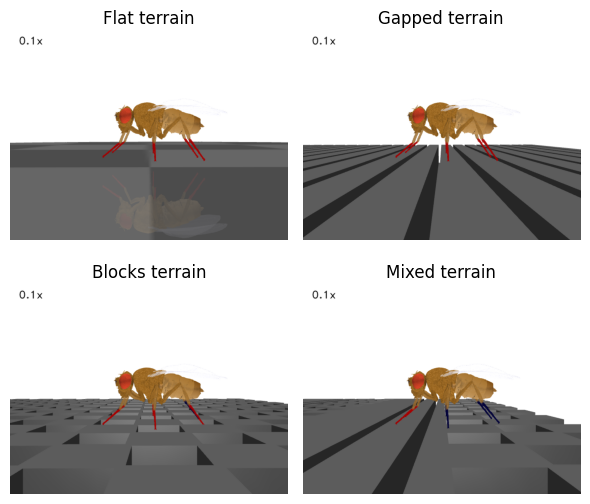

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from flygym import Fly, Camera, SingleFlySimulation
from flygym.examples import PreprogrammedSteps


preprogrammed_steps = PreprogrammedSteps()  # we will use the neutral pose from this

fig, axs = plt.subplots(2, 2, figsize=(6, 6), tight_layout=True)
terrain_types = ["flat", "gapped", "blocks", "mixed"]
for i, terrain_type in tqdm(enumerate(terrain_types)):
    ax = axs.flat[i]
    terrain = get_arena(terrain_type)
    # Initialize NeuroMechFly simulation
    fly = Fly(
        enable_adhesion=True,
        draw_adhesion=True,
        init_pose="stretch",
        control="position",
    )

    cam = Camera(fly=fly, play_speed=0.1)
    sim = SingleFlySimulation(
        fly=fly,
        cameras=[cam],
        timestep=1e-4,
        arena=terrain,
    )
    sim.reset()
    for _ in range(100):
        action = {
            "joints": preprogrammed_steps.default_pose,
            "adhesion": np.ones(6, dtype=np.int32),
        }
        sim.step(action)
        sim.render()
    ax.imshow(sim.cameras[0]._frames[-1])
    ax.axis("off")
    ax.set_title(f"{terrain_type.title()} terrain")

fig.savefig("./outputs/complex_terrain_overview.png")

In [46]:
from flygym.examples.cpg_controller import CPGNetwork, run_cpg_simulation
from flygym.examples.rule_based_controller import (
    RuleBasedSteppingCoordinator,
    construct_rules_graph,
    run_rule_based_simulation,
)

run_time = 0.5
timestep = 1e-4

for controller_name in ["CPG-based", "Rule-based"]:
    for terrain_name in terrain_types:
        print(f"* Running {controller_name} controller on {terrain_name} terrain")

        terrain = get_arena(terrain_name)

        # Initialize the simulation
        fly = Fly(
            enable_adhesion=True,
            draw_adhesion=True,
            init_pose="stretch",
            control="position",
        )

        cam = Camera(fly=fly, play_speed=0.1)
        sim = SingleFlySimulation(
            fly=fly,
            cameras=[cam],
            timestep=1e-4,
            arena=terrain,
        )
        sim.reset()

        if controller_name == "CPG-based":
            intrinsic_freqs = np.ones(6) * 12
            intrinsic_amps = np.ones(6) * 1
            phase_biases = np.pi * np.array(
                [
                    [0, 1, 0, 1, 0, 1],
                    [1, 0, 1, 0, 1, 0],
                    [0, 1, 0, 1, 0, 1],
                    [1, 0, 1, 0, 1, 0],
                    [0, 1, 0, 1, 0, 1],
                    [1, 0, 1, 0, 1, 0],
                ]
            )
            coupling_weights = (phase_biases > 0) * 10
            convergence_coefs = np.ones(6) * 20
            cpg_network = CPGNetwork(
                timestep=timestep,
                intrinsic_freqs=intrinsic_freqs,
                intrinsic_amps=intrinsic_amps,
                coupling_weights=coupling_weights,
                phase_biases=phase_biases,
                convergence_coefs=convergence_coefs,
            )
            run_cpg_simulation(sim, cpg_network, preprogrammed_steps, run_time)
        elif controller_name == "Rule-based":
            weights = {
                "rule1": -10,
                "rule2_ipsi": 2.5,
                "rule2_contra": 1,
                "rule3_ipsi": 3.0,
                "rule3_contra": 2.0,
            }
            rules_graph = construct_rules_graph()
            controller = RuleBasedSteppingCoordinator(
                timestep=timestep,
                rules_graph=rules_graph,
                weights=weights,
                preprogrammed_steps=preprogrammed_steps,
            )
            run_rule_based_simulation(sim, controller, run_time)
        else:
            raise ValueError(f"Unknown controller: {controller}")

        x_pos = sim.get_observation()["fly"][0, 0]
        print(f"Final x position: {x_pos:.4f} mm")

        cam.save_video(f"./outputs/{controller_name}_{terrain_name}.mp4")

* Running CPG-based controller on flat terrain


100%|██████████| 5000/5000 [00:12<00:00, 405.30it/s]


Final x position: 6.3570 mm
* Running CPG-based controller on gapped terrain


100%|██████████| 5000/5000 [00:41<00:00, 121.49it/s]


Final x position: 3.8126 mm
* Running CPG-based controller on blocks terrain


100%|██████████| 5000/5000 [00:39<00:00, 125.29it/s]


Final x position: 4.5470 mm
* Running CPG-based controller on mixed terrain


100%|██████████| 5000/5000 [00:33<00:00, 149.66it/s]


Final x position: 2.7299 mm
* Running Rule-based controller on flat terrain


100%|██████████| 5000/5000 [00:13<00:00, 366.02it/s]


Final x position: 2.0635 mm
* Running Rule-based controller on gapped terrain


100%|██████████| 5000/5000 [00:40<00:00, 123.18it/s]


Final x position: 1.7704 mm
* Running Rule-based controller on blocks terrain


100%|██████████| 5000/5000 [00:41<00:00, 119.06it/s]


Final x position: 1.0217 mm
* Running Rule-based controller on mixed terrain


100%|██████████| 5000/5000 [00:34<00:00, 146.36it/s]


Final x position: 1.9688 mm


# Hybrid controller

In [47]:
stumbling_force_threshold = -1

In [48]:
timestep = 1e-4

# Define leg raise correction vectors
correction_vectors = {
    # "leg pos": (Coxa, Coxa_roll, Coxa_yaw, Femur, Femur_roll, Tibia, Tarsus1)
    # unit: radian
    "F": np.array([-0.03, 0, 0, -0.03, 0, 0.03, 0.03]),
    "M": np.array([-0.015, 0.001, 0.025, -0.02, 0, -0.02, 0.0]),
    "H": np.array([0, 0, 0, -0.02, 0, 0.01, -0.02]),
}

right_leg_inversion = [1, -1, -1, 1, -1, 1, 1]

# Define leg raise rates
correction_rates = {"retraction": (800, 700), "stumbling": (2200, 2100)}
max_increment = 80

# Initialize CPG network
intrinsic_freqs = np.ones(6) * 12
intrinsic_amps = np.ones(6) * 1
phase_biases = np.pi * np.array(
    [
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
    ]
)
coupling_weights = (phase_biases > 0) * 10
convergence_coefs = np.ones(6) * 20

In [49]:
# Initialize preprogrammed steps
preprogrammed_steps = PreprogrammedSteps()

In [50]:
# Initialize NeuroMechFly simulation
# Initialize the simulation

contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in preprogrammed_steps.legs
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]


detected_segments = ["Tibia", "Tarsus1", "Tarsus2"]
stumbling_sensors = {leg: [] for leg in preprogrammed_steps.legs}
for i, sensor_name in enumerate(fly.contact_sensor_placements):
    leg = sensor_name.split("/")[1][:2]  # sensor_name: eg. "Animat/LFTarsus1"
    segment = sensor_name.split("/")[1][2:]
    if segment in detected_segments:
        stumbling_sensors[leg].append(i)
stumbling_sensors = {k: np.array(v) for k, v in stumbling_sensors.items()}

In [51]:
for terrain_name in ["blocks"]:

    retraction_correction = np.zeros(6)
    stumbling_correction = np.zeros(6)

    np.random.seed(4)
    cpg_network = CPGNetwork(
    timestep=1e-4,
    intrinsic_freqs=intrinsic_freqs,
    intrinsic_amps=intrinsic_amps,
    coupling_weights=coupling_weights,
    phase_biases=phase_biases,
    convergence_coefs=convergence_coefs,
    seed=4
    )
    
    run_time = 1
    fly = Fly(
        enable_adhesion=True,
        draw_adhesion=True,
        init_pose="stretch",
        control="position",
        contact_sensor_placements=contact_sensor_placements,
        spawn_pos=[1.85, -0.47, 0.5],
        detect_flip=True,

    )

    cam = Camera(fly=fly, play_speed=0.05, camera_id="Animat/camera_right")
    arena = get_arena(terrain_name)
    sim = SingleFlySimulation(
        fly=fly,
        cameras=[cam],
        timestep=1e-4,
        arena=arena,
    )
    _ = sim.reset()

    flip_counter = []

    print(f"* Running hybrid controller on {terrain_name} terrain")
    detected_segments = ["Tibia", "Tarsus1", "Tarsus2"]
    stumbling_sensors = {leg: [] for leg in preprogrammed_steps.legs}
    for i, sensor_name in enumerate(fly.contact_sensor_placements):
        leg = sensor_name.split("/")[1][:2]  # sensor_name: eg. "Animat/LFTarsus1"
        segment = sensor_name.split("/")[1][2:]
        if segment in detected_segments:
            stumbling_sensors[leg].append(i)
    stumbling_sensors = {k: np.array(v) for k, v in stumbling_sensors.items()}

    obs, info = sim.reset()

    target_num_steps = int(run_time / sim.timestep)
    joint_control = np.zeros((len(fly.actuated_joints), target_num_steps))
    obs_list = []

    all_net_corrections = np.zeros((len(preprogrammed_steps.legs), target_num_steps))
    retraction_persistance = 20
    persistance_init_thr = 20
    retraction_perisitance_counter = np.zeros(6)

    retraction_persistance_counter_hist = np.zeros((6, target_num_steps))

    is_flipped = False

    for k in trange(target_num_steps):
        # retraction rule: does a leg need to be retracted from a hole?
        end_effector_z_pos = obs["fly"][0][2] - obs["end_effectors"][:, 2]
        end_effector_z_pos_sorted_idx = np.argsort(end_effector_z_pos)
        end_effector_z_pos_sorted = end_effector_z_pos[end_effector_z_pos_sorted_idx]
        if end_effector_z_pos_sorted[-1] > end_effector_z_pos_sorted[-3] + 0.05:
            leg_to_correct_retraction = end_effector_z_pos_sorted_idx[-1]
            if retraction_correction[leg_to_correct_retraction] > persistance_init_thr:
                retraction_perisitance_counter[leg_to_correct_retraction] = 1 
        else:
            leg_to_correct_retraction = None
        
        # update persistance counter
        retraction_perisitance_counter[retraction_perisitance_counter > 0] += 1
        retraction_perisitance_counter[retraction_perisitance_counter > retraction_persistance] = 0
        retraction_persistance_counter_hist[:, k] = retraction_perisitance_counter

        cpg_network.step()
        joints_angles = []
        adhesion_onoff = []

        for i, leg in enumerate(preprogrammed_steps.legs):
            # update amount of retraction correction
            if i == leg_to_correct_retraction or retraction_perisitance_counter[i] > 0:  # lift leg
                increment = correction_rates["retraction"][0] * sim.timestep
                retraction_correction[i] += increment
                fly.change_segment_color(sim.physics, f"{leg}Tibia", (1, 0, 0, 1))
            else:  # condition no longer met, lower leg
                decrement = correction_rates["retraction"][1] * sim.timestep
                retraction_correction[i] = max(0, retraction_correction[i] - decrement)
                fly.change_segment_color(sim.physics, f"{leg}Tibia", (0.5, 0.5, 0.5, 1))

            # update amount of stumbling correction
            contact_forces = obs["contact_forces"][stumbling_sensors[leg], :]
            fly_orientation = obs["fly_orientation"]
            # force projection should be negative if against fly orientation
            force_proj = np.dot(contact_forces, fly_orientation)
            if (force_proj < stumbling_force_threshold).any():
                increment = correction_rates["stumbling"][0] * sim.timestep
                stumbling_correction[i] += increment
                fly.change_segment_color(sim.physics, f"{leg}Femur", (1, 0, 0, 1))
            else:
                decrement = correction_rates["stumbling"][1] * sim.timestep
                stumbling_correction[i] = max(0, stumbling_correction[i] - decrement)
                fly.change_segment_color(sim.physics, f"{leg}Femur", (0.5, 0.5, 0.5, 1))

            # retraction correction is prioritized
            if retraction_correction[i] > 0:
                net_correction = retraction_correction[i]
                stumbling_correction[i] = 0
            else:
                net_correction = stumbling_correction[i]

            # get target angles from CPGs and apply correction
            my_joints_angles = preprogrammed_steps.get_joint_angles(
                leg, cpg_network.curr_phases[i], cpg_network.curr_magnitudes[i]
            )
            net_correction = min(net_correction, max_increment)
            if leg[0] == "R":
                net_correction *= right_leg_inversion[i]
            all_net_corrections[i, k] = net_correction

            my_joints_angles += net_correction * correction_vectors[leg[1]]
            joints_angles.append(my_joints_angles)

            # get adhesion on/off signal
            my_adhesion_onoff = preprogrammed_steps.get_adhesion_onoff(
                leg, cpg_network.curr_phases[i]
            )
            # No adhesion in stumbling or retracted
            my_adhesion_onoff *= np.logical_not((force_proj < stumbling_force_threshold).any() or
                                                 i == leg_to_correct_retraction)
            adhesion_onoff.append(my_adhesion_onoff)

        action = {
            "joints": np.array(np.concatenate(joints_angles)),
            "adhesion": np.array(adhesion_onoff).astype(int),
        }
        joint_control[:, k] = action["joints"]

        obs, reward, terminated, truncated, info = sim.step(action)
        obs_list.append(obs)

        if is_flipped != info["flip"]:
            print(f"Flipped at step {k}")
            is_flipped = info["flip"]
        
        flip_counter.append(fly.flip_counter)

        sim.render()
        
    cam.save_video(f"./outputs/hybrid_controller_{terrain_name}_terrain.mp4", 0)
    x_pos = sim.get_observation()["fly"][0, 0]
    print(f"Final x position: {x_pos:.4f} mm")

* Running hybrid controller on blocks terrain


100%|██████████| 10000/10000 [01:26<00:00, 115.70it/s]


Final x position: 13.2217 mm


In [52]:
obs["fly"][2]/np.pi

array([0.5871477 , 0.00896322, 0.24627414], dtype=float32)

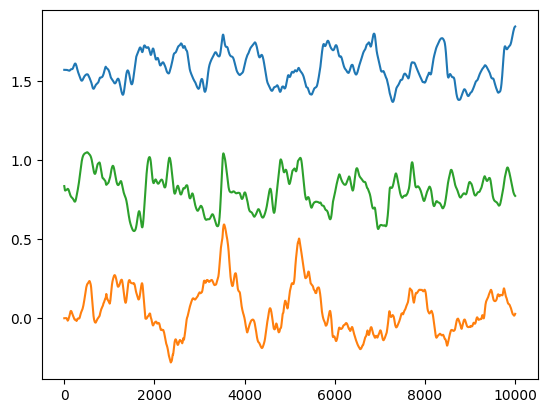

In [53]:
fly_or = [obs["fly"][2] for obs in obs_list]
plt.plot(fly_or)


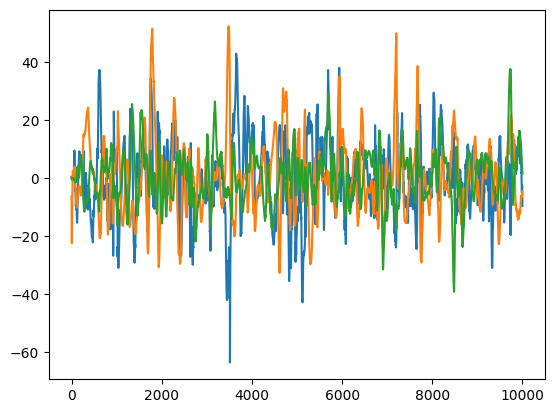

In [54]:
fly_rotvel = [obs["fly"][3] for obs in obs_list]
plt.plot(fly_rotvel)

In [55]:
fly_or[-1] - fly_or[0]

array([ 0.27403104,  0.02784323, -0.06194115], dtype=float32)

In [56]:
cam.save_video(f"./outputs/hybrid_controller_{terrain_name}_terrain.mp4", 0)

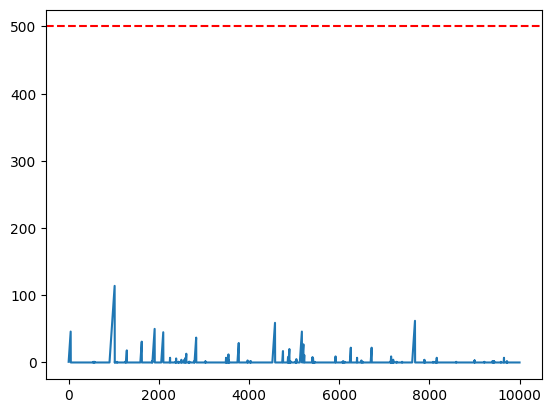

In [57]:
plt.plot(flip_counter)
plt.axhline(fly.config["flip_detection"]["min_flip_duration"]/sim.timestep, color="red", linestyle="--")

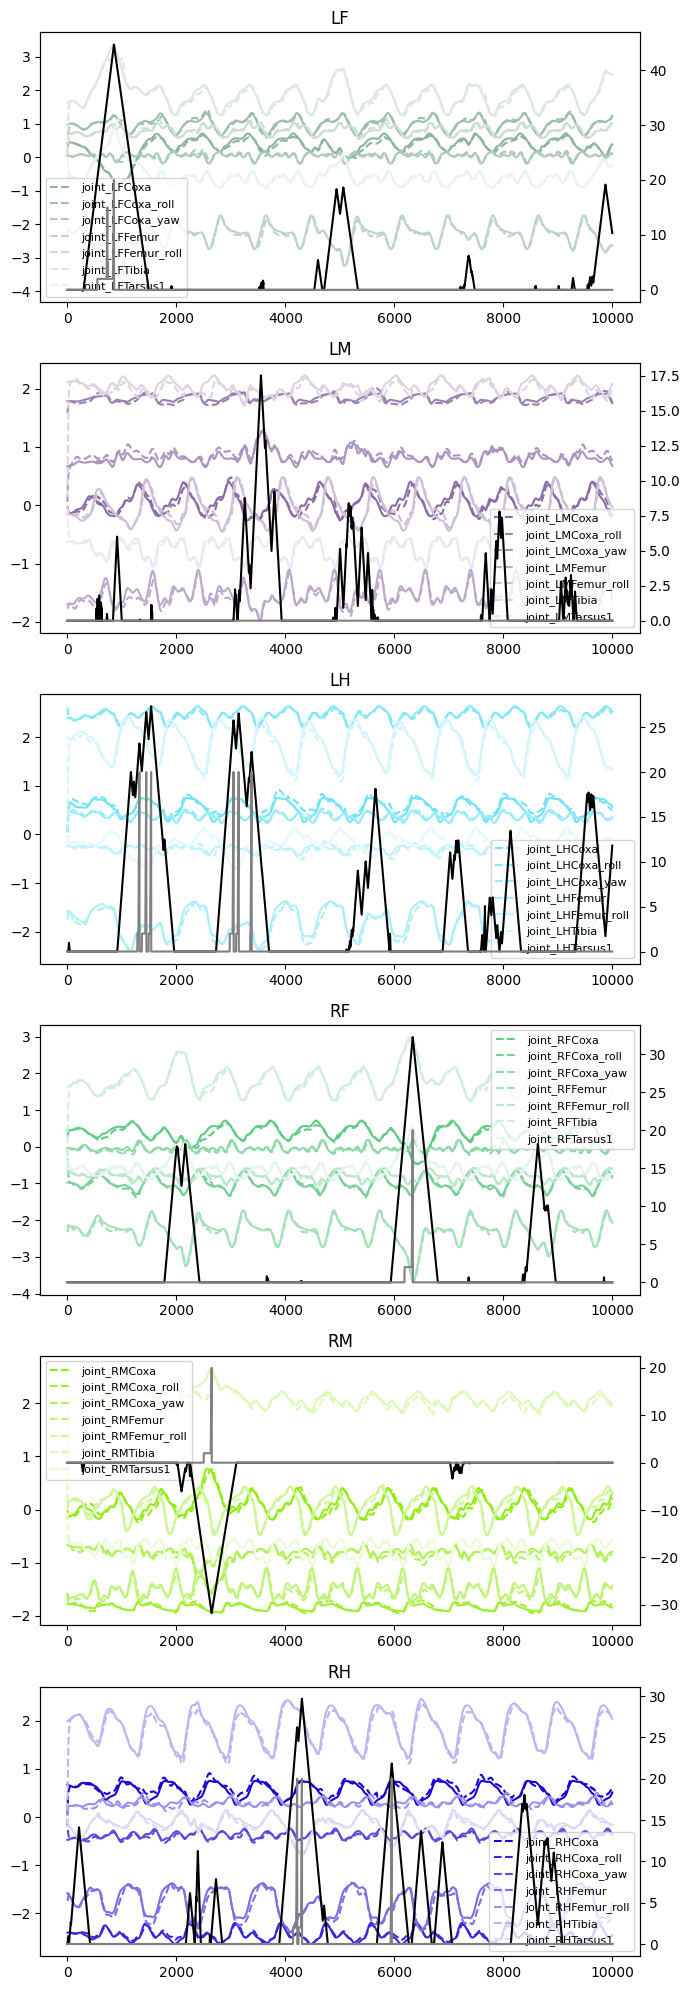

In [58]:
joint_obs = [o["joints"][0] for o in obs_list]
joint_obs = np.array(joint_obs)

fig, axs = plt.subplots(6, 1, figsize=(7, 20), tight_layout=True)
np.random.seed(0)
for i, leg in enumerate(preprogrammed_steps.legs):
    c = np.random.rand(3)
    color_increment = (0.99-c)/7 # number of joints in a leg
    ci = 0
    for j, act_jnt in enumerate(fly.actuated_joints):
        if leg in act_jnt:
            axs[i].plot(joint_obs[:, j], label=act_jnt, ls="--", color = c+ci*color_increment)
            axs[i].plot(joint_control[j, :], color = c+ci*color_increment)
            ci+=1
    twin_ax = axs[i].twinx()
    twin_ax.plot(all_net_corrections[i, :], label="net correction", color = "black")
    twin_ax.plot(retraction_persistance_counter_hist[i, :], label="retraction persistance", color = "grey")
    axs[i].legend(fontsize=8)
    axs[i].set_title(f"{leg}")

At each simulation time step, we first check whether the retraction rule is met. This depends on whether any leg is extended further than the third most extended leg in the z-direction by a margin of 0.05 mm. This margin is important because contact calculations in the physics simulator are imperfect sometimes causing the leg to penetrate the floor by a small amount. If two legs meet this condition, only the most extended leg is corrected:

```Python
    # retraction rule: does a leg need to be retracted from a hole?
    end_effector_z_pos = obs["fly"][0][2] - obs["end_effectors"][:, 2]
    end_effector_z_pos_sorted_idx = np.argsort(end_effector_z_pos)
    end_effector_z_pos_sorted = end_effector_z_pos[end_effector_z_pos_sorted_idx]
    if end_effector_z_pos_sorted[-1] > end_effector_z_pos_sorted[-3] + 0.05:
        leg_to_correct_retraction = end_effector_z_pos_sorted_idx[-1]
    else:
        leg_to_correct_retraction = None
```

Then, have an inner loop that iterates over all legs. The joint angles and adhesion on/off signals are calculated here. We first update the amount of correction :math:`c` for the retraction rule:

```Python
        # update amount of retraction correction
        if i == leg_to_correct_retraction:  # lift leg
            increment = correction_rates["retraction"][0] * nmf.timestep
            retraction_correction[i] += increment
            nmf.change_segment_color(sim.physics, f"{leg}Tibia", (1, 0, 0, 1))
        else:  # condition no longer met, lower leg
            decrement = correction_rates["retraction"][1] * nmf.timestep
            retraction_correction[i] = max(0, retraction_correction[i] - decrement)
            nmf.change_segment_color(sim.physics, f"{leg}Tibia", (0.5, 0.5, 0.5, 1))
```

Similarly, we update the correction amount $c$ for the stumbling rule:

```Python
        # update amount of stumbling correction
        contact_forces = obs["contact_forces"][stumbling_sensors[leg], :]
        fly_orientation = obs["fly_orientation"]
        # force projection should be negative if against fly orientation
        force_proj = np.dot(contact_forces, fly_orientation)
        if (force_proj < stumbling_force_threshold).any():
            increment = correction_rates["stumbling"][0] * nmf.timestep
            stumbling_correction[i] += increment
            nmf.change_segment_color(sim.physics, f"{leg}Femur", (1, 0, 0, 1))
        else:
            decrement = correction_rates["stumbling"][1] * nmf.timestep
            stumbling_correction[i] = max(0, stumbling_correction[i] - decrement)
            nmf.change_segment_color(sim.physics, f"{leg}Femur", (0.5, 0.5, 0.5, 1))
```

In the case that both rules are active for the same leg, we will only apply the retraction correction:

```Python
        # retraction correction is prioritized
        if retraction_correction[i] > 0:
            net_correction = retraction_correction[i]
        else:
            net_correction = stumbling_correction[i]
```

Let’s first obtain the initial joint angles based purely on the CPG phase and preprogrammed step. Then, we will apply the lifting correction:

```Python
        # get target angles from CPGs and apply correction
        my_joints_angles = preprogrammed_steps.get_joint_angles(
            leg, cpg_network.curr_phases[i], cpg_network.curr_magnitudes[i]
        )
        my_joints_angles += net_correction * correction_vectors[leg[1]]
        joints_angles.append(my_joints_angles)
```

Finally, we can get the adhesion on/off signal based on the leg phase as well:

```Python
        # get adhesion on/off signal
        my_adhesion_onoff = preprogrammed_steps.get_adhesion_onoff(
            leg, cpg_network.curr_phases[i]
        )
        adhesion_onoff.append(my_adhesion_onoff)
```

We now have all we need to feed the action into the NeuroMechFly simulation. Don’t forget to call `.render()` to record the video correctly.

```Python
    action = {
        "joints": np.array(np.concatenate(joints_angles)),
        "adhesion": np.array(adhesion_onoff).astype(int),
    }
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()
```


Let's visualize the results:

In [59]:
cam.save_video("./outputs/hybrid_controller_mixed_terrain.mp4")

<video width="400" controls>
  <source src="https://raw.githubusercontent.com/NeLy-EPFL/_media/main/flygym/hybrid_controller_mixed_terrain.mp4" type="video/mp4">
</video>

Even based on this single example, this hybrid controller looks better than the CPG-based or rule-based controller. Indeed, we obtained the following results by running 20 simulations for each controller over each terrain type with different initial conditions. These show that a hybrid controller outperforms the other two controllers (see the NeuroMechFly 2.0 paper for details):

<img src="https://github.com/NeLy-EPFL/_media/blob/main/flygym/cpg_rule_based_hybrid_comparison.png?raw=true" alt="cpg_rule_based_comparison" width="800"/>

These results demonstrate how rugged terrain can expose failure modes for controllers that otherwise work well on flat terrain, and how you can use NeuroMechFly to benchmark different control strategies that go beyond the classical dichotomy of CPG-based versus rule-based control.

In the next tutorial, we will refactor our hybrid controller code into a Python class that implements the Gym interface. This will allow us to show how to build control models with different degrees of abstraction and preprogrammed computations.